# Датасет №4 "German Credit Risk"

### Описание датасета

В этом наборе данных каждая запись представляет человека, который берет кредит в банке. Каждый человек классифицируется как хороший или плохой кредитный риск в соответствии с набором атрибутов. 

---

Информация об атрибутах:

- Возраст (числовое значение)
- Пол (текст: мужской, женский)
- Работа (числовое значение: 0 - неквалифицированный и нерезидент, 1 - неквалифицированный и резидент, 2 - квалифицированный, 3 - высококвалифицированный)
- Жилье (текст: собственное, арендуемое или свободное)
- Сберегательные счета (текст - небольшой, умеренный, довольно богатый, богатый)
- Расчетный счет (числовое значение, в DM - немецких марках)
- Сумма кредита (числовое значение, в DM)
- Срок (числовое значение, в месяцах)
- Цель (текст: автомобиль, мебель/оборудование, радио/ТВ, бытовая техника, ремонт, образование, бизнес, отпуск/другое)



### Импорт модулей

In [145]:
# импорт стандартных модулей 

import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt

from collections import Counter

In [146]:
# иморт модулей sklearn'а

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Загрузка датасета и подготовка данных

Файл я брала с выгруженного на свой гитхаб репозитория

In [147]:
df = pd.read_csv('https://raw.githubusercontent.com/almondloverr/ml_exam/main/datasets/german_credit_data.csv', index_col=[0])
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [148]:
print("В датасете", df.shape[0], "точек данных и", df.shape[1], "параметров")

В датасете 1000 точек данных и 9 параметров


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [150]:
df.columns # Job — наша целевая переменная

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [151]:
df['Job'].value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

In [152]:
df.describe().T # описательная статистика по числовым параметрам

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


In [153]:
df.describe(include=object).T # описательная статистика по категориальным параметрам

,count,unique,top,freq
Sex,1000,2,male,690
Housing,1000,3,own,713
Saving accounts,817,4,little,603
Checking account,606,3,little,274
Purpose,1000,8,car,337


### Обработка пустых значений 

In [154]:
df.isna().sum()[df.isna().sum() > 0]

Saving accounts     183
Checking account    394
dtype: int64

Предисловие: на одной из лекций коротеев говорил, что наиболее корректным способом для обработки пропусков является не замена на самое частое значение или медиану, а выделение нового атрибута, который мы потом будем рассматривать как отдельный класс, то мы так и сделаем. 

А так дальше мы в любом случае будем менять категориальные значения на числовые через лейбл энкодер (где по дефолту пропущенным значениям присваивается класс 0), то никаких операций с пустыми значениями мы проводить не будем

### Выводим текстовые атрибуты и их уникальные значения для дальнейшего анализа

In [155]:
for column in df.select_dtypes(include='object').columns.tolist():
  print(f'{column}\n{df[column].value_counts()}\n')

Sex
male      690
female    310
Name: Sex, dtype: int64

Housing
own     713
rent    179
free    108
Name: Housing, dtype: int64

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

Checking account
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64



Переменные Sex и Housing заменим на числовые через dummy-переменные

In [156]:
df_sex = pd.get_dummies(df['Sex']).rename(columns={'male': 'Sex_male', 'female': 'Sex_female'})
df = df.join(df_sex).drop('Sex', axis=1)

In [157]:
df_housing = pd.get_dummies(df['Housing']).rename(columns={'own': 'Housing_own', 'rent': 'Housing_rent', 'free': 'Housing_free'})
df = df.join(df_housing).drop('Housing', axis=1)

Остальные категориальные переменные заменим через LabelEncoder, так как параметров слишком много и использовать дамми-переменные нецелесообразно

In [158]:
labelencoder = LabelEncoder()
for col in df.columns:
    df[col] = labelencoder.fit_transform(df[col])
 
df.head()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent
0,48,2,4,0,142,2,5,0,1,0,1,0
1,3,2,0,1,770,29,5,1,0,0,1,0
2,30,1,0,3,390,8,3,0,1,0,1,0
3,26,2,0,0,848,26,4,0,1,1,0,0
4,34,2,0,0,734,17,1,0,1,1,0,0


In [159]:
df.dtypes

Age                 int64
Job                 int64
Saving accounts     int64
Checking account    int64
Credit amount       int64
Duration            int64
Purpose             int64
Sex_female          int64
Sex_male            int64
Housing_free        int64
Housing_own         int64
Housing_rent        int64
dtype: object

In [160]:
df.shape

(1000, 12)

### Визуализация данных

#### Построим гистограммы, чтобы проанализировать распределение каждого из признаков

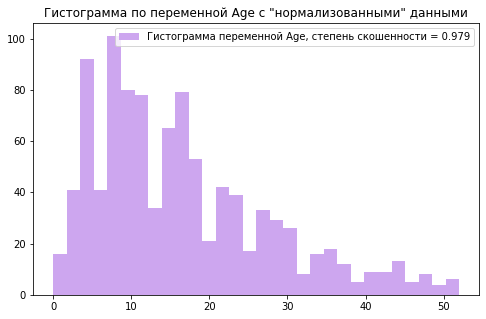

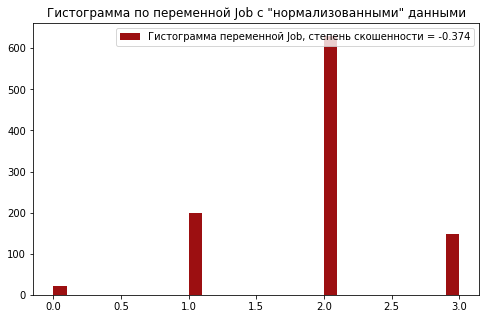

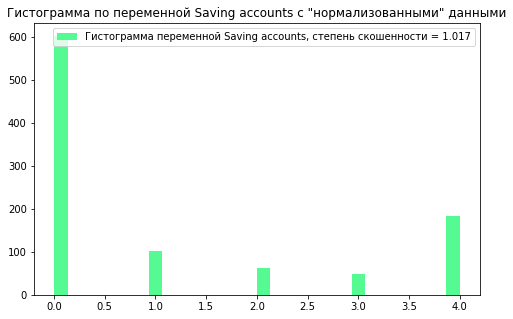

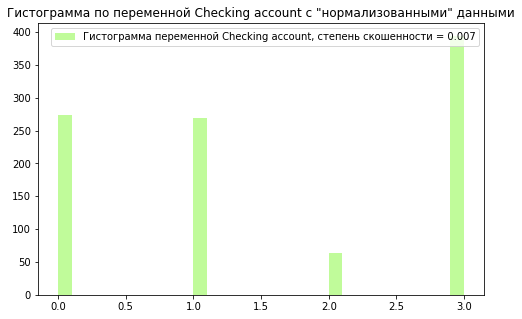

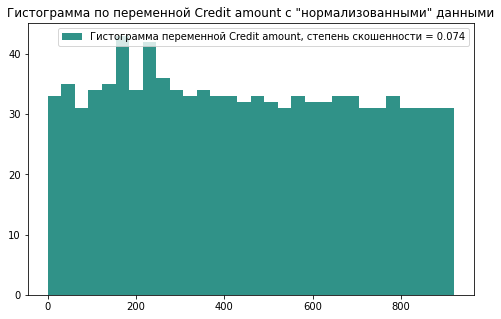

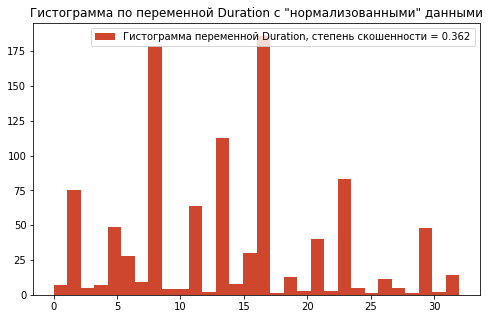

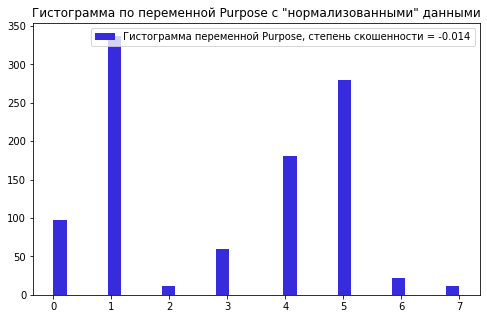

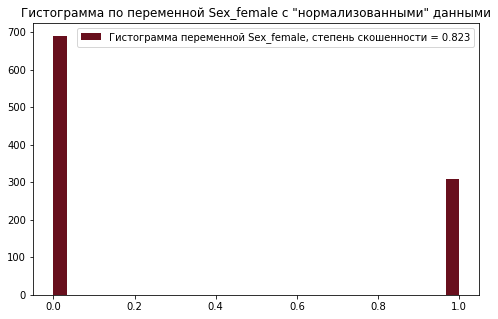

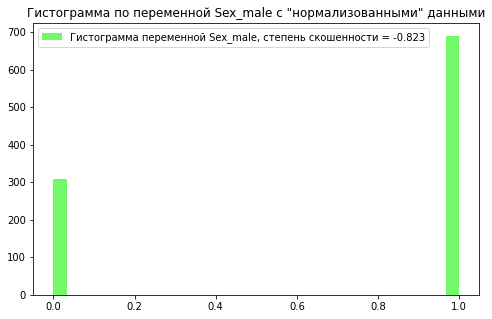

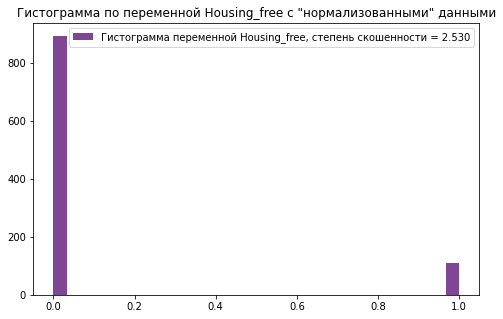

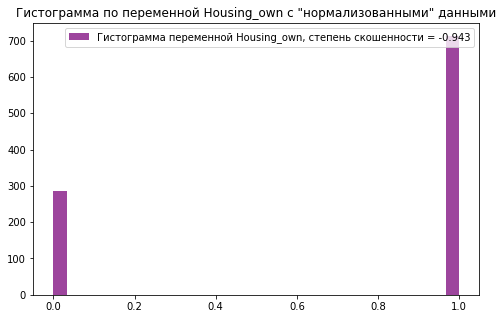

In [161]:
for feat in df.columns[:-1].tolist():
    plt.figure(figsize=(8, 5)) 
    plt.hist(df[feat], color=np.random.rand(3,), label=f'Гистограмма переменной {feat}, степень скошенности = %.3f'%(df[feat].skew()), bins=30) 
    plt.title(f'Гистограмма по переменной {feat} с "нормализованными" данными')
    plt.legend(loc='best')
    plt.show()

Ни одна из характеристик не имеет нормального распределения. Характеристики Fe, Ba, Ca и K имеют самые высокие коэффициенты перекоса. Более того, распределение калия (K) и бария (Ba), похоже, содержит много выбросов.

#### Построим ящики с усами, чтобы проанализировать датасет на наличие выбросов

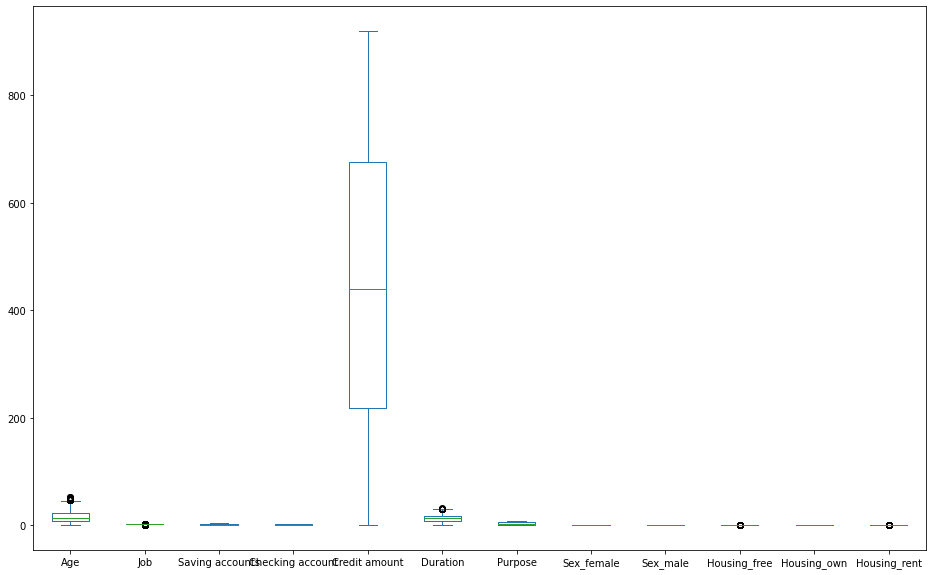

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(16,10))
df.plot(kind='box', ax=ax)

#### Посмотрим, как признаки коррелируют между собой 

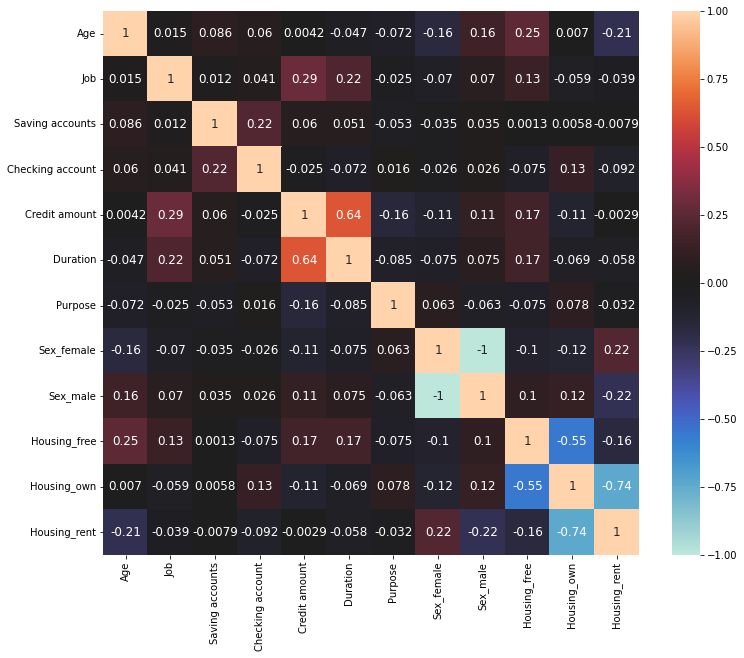

In [163]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 12}, vmin=-1, vmax=1, center=0)

### Очищаем датасет от выбросов 

In [164]:
def outliers(df):
  
  outlier_idx = []

  for col in df.columns.tolist():
    # считаем нижнюю и верхнюю границу через 1 и 3 квартили 
    q25 = df[col].quantile(q=.25)
    q75 = df[col].quantile(q=.75)
    iqr = q75-q25

    max_border = q75 + (1.5*iqr)
    min_border = q25 - (1.5*iqr)
        
    # определем индекс строки, содержащей выбросы
    outlier_list_col = df[(df[col] < min_border) | (df[col] > max_border)].index
    
    # заполняем найденными индеками массив со всеми индексами
    outlier_idx.extend(outlier_list_col)
    
  # выбираем индексы строк, содержащих больше чем два выброса
  outlier_idx = Counter(outlier_idx)        
  multiple_outliers = list( k for k, v in outlier_idx.items() if v > 2 )
  
  return multiple_outliers   

print(f'Этот датасет содержит {len(outliers(df[df.columns[:-1].tolist()]))} точек данных с более чем 2 выбросами')   

Этот датасет содержит 9 точек данных с более чем 2 выбросами


Очищаем лишние строки, 

In [165]:
df = df.drop(outliers(df[df.columns[:-1].tolist()])).reset_index(drop=True)
df.shape

(991, 12)

### Выделяем целевую переменную и остальные признаки

In [166]:
y = df['Job']
x = df.drop(['Job'], axis=1)

### Разделяем выбору в соотношении 80/20 процентов, `shuffle=False` для исключения перемешивания данных

In [167]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=True)

In [168]:
print(f'Количество точек исходных данных: {y.shape[0]}')
print(f'Количество точек тренировочных данных: {y_train.shape[0]}')
print(f'Количество точек тестовых данных: {y_test.shape[0]}')

Количество точек исходных данных: 991
Количество точек тренировочных данных: 792
Количество точек тестовых данных: 199


### Нормализуем наши данные 

Я использую для этого МинМаксСкалер, можно еще использовать СтандартСкалер

In [169]:
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

### Задача классификации

Так как этих методов дохуя, сделаем классификацию с использованием основных пяти: 
- логистическая регрессия 
- метод опорных векторов (линейное ядрос)
- метод опорных векторов (гауссовое ядро)
- метод k ближайших соседей 
- метод деревая решений 

#### Логистическая регрессия

In [170]:
from sklearn.linear_model import LogisticRegression

In [171]:
cls = LogisticRegression(solver='lbfgs', max_iter=1000).fit(x_train, y_train)
y_pred_cls = cls.predict(x_test)

matrix_cls = metrics.confusion_matrix(y_test, y_pred_cls)
print(matrix_cls)

[[  0   1   3   0]
 [  0   0  42   0]
 [  0   1 122   1]
 [  0   1  28   0]]


In [172]:
print(f'Метрика достоверности (logistic): {metrics.accuracy_score(y_test, y_pred_cls)}')
print(f'Метрика точности (logistic): {metrics.precision_score(y_test, y_pred_cls, average = "macro", zero_division=1)}')
print(f'Метрика полноты (logistic): {metrics.recall_score(y_test, y_pred_cls, average = "macro")}')

Метрика достоверности (logistic): 0.6130653266331658
Метрика точности (logistic): 0.4064102564102564
Метрика полноты (logistic): 0.24596774193548387


#### Метод опорных векторов с линейным ядром 

In [173]:
from sklearn import svm

In [174]:
svc = svm.SVC(kernel='linear', probability=True).fit(x_train, y_train)
y_pred_svc = svc.predict(x_test)

matrix_svc = metrics.confusion_matrix(y_test, y_pred_svc)
print(matrix_svc)

[[  0   0   4   0]
 [  0   0  42   0]
 [  0   0 124   0]
 [  0   0  29   0]]


In [175]:
print(f'Метрика достоверности (svc linear): {metrics.accuracy_score(y_test, y_pred_svc)}')
print(f'Метрика точности (svc linear): {metrics.precision_score(y_test, y_pred_svc, average = "macro", zero_division=1)}')
print(f'Метрика полноты (svc linear): {metrics.recall_score(y_test, y_pred_svc, average = "macro")}')

Метрика достоверности (svc linear): 0.6231155778894473
Метрика точности (svc linear): 0.9057788944723618
Метрика полноты (svc linear): 0.25


#### Метод опорных векторов с гауссовым ядром 

In [176]:
svc_g = svm.SVC(kernel='rbf', probability=True).fit(x_train, y_train)
y_pred_svc_g = svc_g.predict(x_test)

matrix_svc_g = metrics.confusion_matrix(y_test, y_pred_svc_g)
print(matrix_svc_g)

[[  0   0   4   0]
 [  0   0  42   0]
 [  0   0 124   0]
 [  0   0  29   0]]


In [177]:
print(f'Метрика достоверности (svc rbf): {metrics.accuracy_score(y_test, y_pred_svc_g)}')
print(f'Метрика точности (svc rbf): {metrics.precision_score(y_test, y_pred_svc_g, average = "macro", zero_division=1)}')
print(f'Метрика полноты (svc rbf): {metrics.recall_score(y_test, y_pred_svc_g, average = "macro")}')

Метрика достоверности (svc rbf): 0.6231155778894473
Метрика точности (svc rbf): 0.9057788944723618
Метрика полноты (svc rbf): 0.25


#### Метод k ближайших соседей

In [178]:
from sklearn.neighbors import KNeighborsClassifier

In [179]:
# количество соседей n_neighbors = 10 подбирала вручную, проверку делала на метрике точности
kn = KNeighborsClassifier(n_neighbors=10).fit(x_train, y_train)
y_pred_kn = kn.predict(x_test)

matrix_kn = metrics.confusion_matrix(y_test, y_pred_kn)
print(matrix_kn)

[[  0   2   2   0]
 [  0   5  37   0]
 [  0   8 110   6]
 [  0   1  26   2]]


In [180]:
print(f'Метрика достоверности (KN): {metrics.accuracy_score(y_test, y_pred_kn)}')
print(f'Метрика точности (KN): {metrics.precision_score(y_test, y_pred_kn, average = "macro", zero_division=1)}')
print(f'Метрика полноты (KN): {metrics.recall_score(y_test, y_pred_kn, average = "macro")}')

Метрика достоверности (KN): 0.5879396984924623
Метрика точности (KN): 0.5477678571428571
Метрика полноты (KN): 0.26877747762063664


### Метод дерева решений 

In [181]:
from sklearn.tree import DecisionTreeClassifier

In [182]:
dt = DecisionTreeClassifier().fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)

matrix_dt = metrics.confusion_matrix(y_test, y_pred_dt)
print(matrix_dt)

[[ 1  2  0  1]
 [ 2  7 32  1]
 [ 2 24 85 13]
 [ 2  5 11 11]]


In [183]:
print(f'Метрика достоверности (dec tree): {metrics.accuracy_score(y_test, y_pred_dt)}') 
print(f'Метрика точности (dec tree): {metrics.precision_score(y_test, y_pred_dt, average = "macro")}')
print(f'Метрика полноты (dec tree): {metrics.recall_score(y_test, y_pred_dt, average = "macro")}')

Метрика достоверности (dec tree): 0.5226130653266332
Метрика точности (dec tree): 0.3535517730624638
Метрика полноты (dec tree): 0.3703652206154987


### Оценка эффективности обучения моделей (метрики)

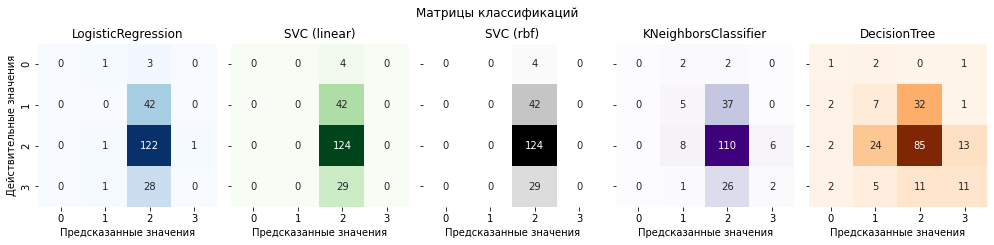

In [184]:
class_names = [0, 1]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(17, 3), sharey=True) 

ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)

sns.heatmap(data=pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_cls)), 
            ax=ax1, annot=True, cbar=False, cmap='Blues', fmt='.4g')
sns.heatmap(data=pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_svc)), 
            ax=ax2, annot=True, cbar=False, cmap='Greens', fmt='.4g')
sns.heatmap(data=pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_svc_g)), 
            ax=ax3, annot=True, cbar=False, cmap='Greys', fmt='.4g')
sns.heatmap(data=pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_kn)), 
            ax=ax4, annot=True, cbar=False, cmap='Purples', fmt='.4g')
sns.heatmap(data=pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_dt)), 
            ax=ax5, annot=True, cbar=False, cmap='Oranges', fmt='.4g')

ax1.set_title('LogisticRegression')
ax2.set_title('SVC (linear)')
ax3.set_title('SVC (rbf)')
ax4.set_title('KNeighborsClassifier')
ax5.set_title('DecisionTree')

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set(xlabel='Предсказанные значения', ylabel='Действительные значения')
    ax.label_outer()

fig.subplots_adjust(wspace=0.08)

plt.suptitle('Матрицы классификаций', y = 1.05)
plt.show()

In [185]:
clas = {'LogisticRegression': y_pred_cls, 'SVC linear': y_pred_svc, 
        'SVC rbf': y_pred_svc_g, 'KNeighbors': y_pred_kn, 'DecisionTree': y_pred_dt}

for n, y_pred in clas.items():
  print(f'Достоверность ({n}): {metrics.accuracy_score(y_test, y_pred)}')
  print(f'Точность ({n}): {metrics.precision_score(y_test, y_pred, average = "macro", zero_division=1)}')
  print(f'Полнота ({n}): {metrics.recall_score(y_test, y_pred, average = "macro")}\n')

Достоверность (LogisticRegression): 0.6130653266331658
Точность (LogisticRegression): 0.4064102564102564
Полнота (LogisticRegression): 0.24596774193548387

Достоверность (SVC linear): 0.6231155778894473
Точность (SVC linear): 0.9057788944723618
Полнота (SVC linear): 0.25

Достоверность (SVC rbf): 0.6231155778894473
Точность (SVC rbf): 0.9057788944723618
Полнота (SVC rbf): 0.25

Достоверность (KNeighbors): 0.5879396984924623
Точность (KNeighbors): 0.5477678571428571
Полнота (KNeighbors): 0.26877747762063664

Достоверность (DecisionTree): 0.5226130653266332
Точность (DecisionTree): 0.3535517730624638
Полнота (DecisionTree): 0.3703652206154987



**На основе метрик мы видим, что наиболее хорошо показала себя модель метода опорных векторов** 

### Выводы об обученности моделей 

### Вывод о недообученности/переобученности модели

In [186]:
acc_cls = metrics.accuracy_score(y_test, y_pred_cls)
acc_svc = metrics.accuracy_score(y_test, y_pred_svc)
acc_svc_g = metrics.accuracy_score(y_test, y_pred_svc_g)
acc_kn = metrics.accuracy_score(y_test, y_pred_kn)
acc_dt = metrics.accuracy_score(y_test, y_pred_dt)

acc_train_cls = metrics.accuracy_score(y_train, cls.predict(x_train))
acc_train_svc = metrics.accuracy_score(y_train, svc.predict(x_train))
acc_train_svc_g = metrics.accuracy_score(y_train, svc_g.predict(x_train))
acc_train_kn = metrics.accuracy_score(y_train, kn.predict(x_train))
acc_train_dt = metrics.accuracy_score(y_train, dt.predict(x_train))

In [187]:
trained = pd.DataFrame(columns = ['test data', 'train data'])

logistic = [acc_cls, acc_train_cls]
svm = [acc_svc, acc_train_svc]
svm_g = [acc_svc, acc_train_svc]
kneighbors = [acc_kn, acc_train_kn]
dtree = [acc_dt, acc_train_dt]

trained.loc[0] = logistic
trained.loc[1] = svm
trained.loc[2] = svm_g
trained.loc[3] = kneighbors
trained.loc[4] = dtree

trained['result'] = trained.apply(lambda x: 'обучена адекватно' if (abs(x['test data'] - x['train data']) <= 0.015) else 
                                  ('недообучена' if (x['test data'] > x['train data']) else 'переобучена'), axis=1)
trained.set_axis(['LogisticRegression', 'SVC linear', 'SVC rbf', 'KNeighbors', 'DecisionTree'], axis='index', inplace=True)

trained

,test data,train data,result
LogisticRegression,0.613065,0.640152,переобучена
SVC linear,0.623116,0.638889,переобучена
SVC rbf,0.623116,0.638889,переобучена
KNeighbors,0.587940,0.651515,переобучена
DecisionTree,0.522613,1.000000,переобучена
